# 0. Understanding the problem, the requirements and the goal

Predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

# 1. Dataset Analysis

We import all libraries and packages we will be using for this ML process

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, Normalizer, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import warnings
from scipy.stats.mstats import winsorize
import time

We set certain type of view, for improving visualizations of piplines and graphs, also set off warnings

In [2]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [3]:
sklearn.set_config(display='diagram')
sns.set_style('whitegrid')

read the csv for the training and for the final test, df_test will not be part of the modeling, it will only serve for predicting and uploading to kaggle

In [4]:
df_train = pd.read_csv('train.csv').set_index('Id')
df_test = pd.read_csv('test.csv').set_index('Id')

In [5]:
X = df_train.drop(columns='Cover_Type')
y = df_train['Cover_Type']

Of the Training dataset, we will define X and y for the model and then we will split it into training and test dataset, we started spliting the dataset into 80-20% but after we felt confortable with the result of the crossvalidation, we lower it until almost test being unexistant. Rational: we are already validating the result with Kaggle results, there was no reason to use more data for validation, so we use used almost all the dataset to train after we felt confident regarding our model.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0005)

In [7]:
X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1599,2823,80,33,270,-95,300,242,161,22,2510,...,0,0,0,0,0,0,0,0,0,0
1297,3106,83,6,180,-8,4254,228,230,137,1519,...,0,0,0,0,0,0,0,0,0,0
7364,2701,20,11,85,0,2412,212,217,140,525,...,1,0,0,0,0,0,0,0,0,0
519,2983,5,5,400,-6,3406,213,230,154,5600,...,0,0,0,0,0,0,0,0,0,0
3586,2016,352,10,0,0,330,203,223,158,417,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train.shape

(15112, 54)

## 2. Preprocessing & Cleaning

2.1 Null Values

We started by analyzing null data, to see if we needed to impute certain missing values. That was not necesary since there are no null values in this dataset.

In [9]:
X_train.isnull().sum().sum()

0

We needed to be sure that all features where integers before starting, so we print data types to make sure of it.

In [10]:
X_train.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

There are no nulls and the types are in the correct format.

2.2 Scalers

We started with a overall visual look of the features.


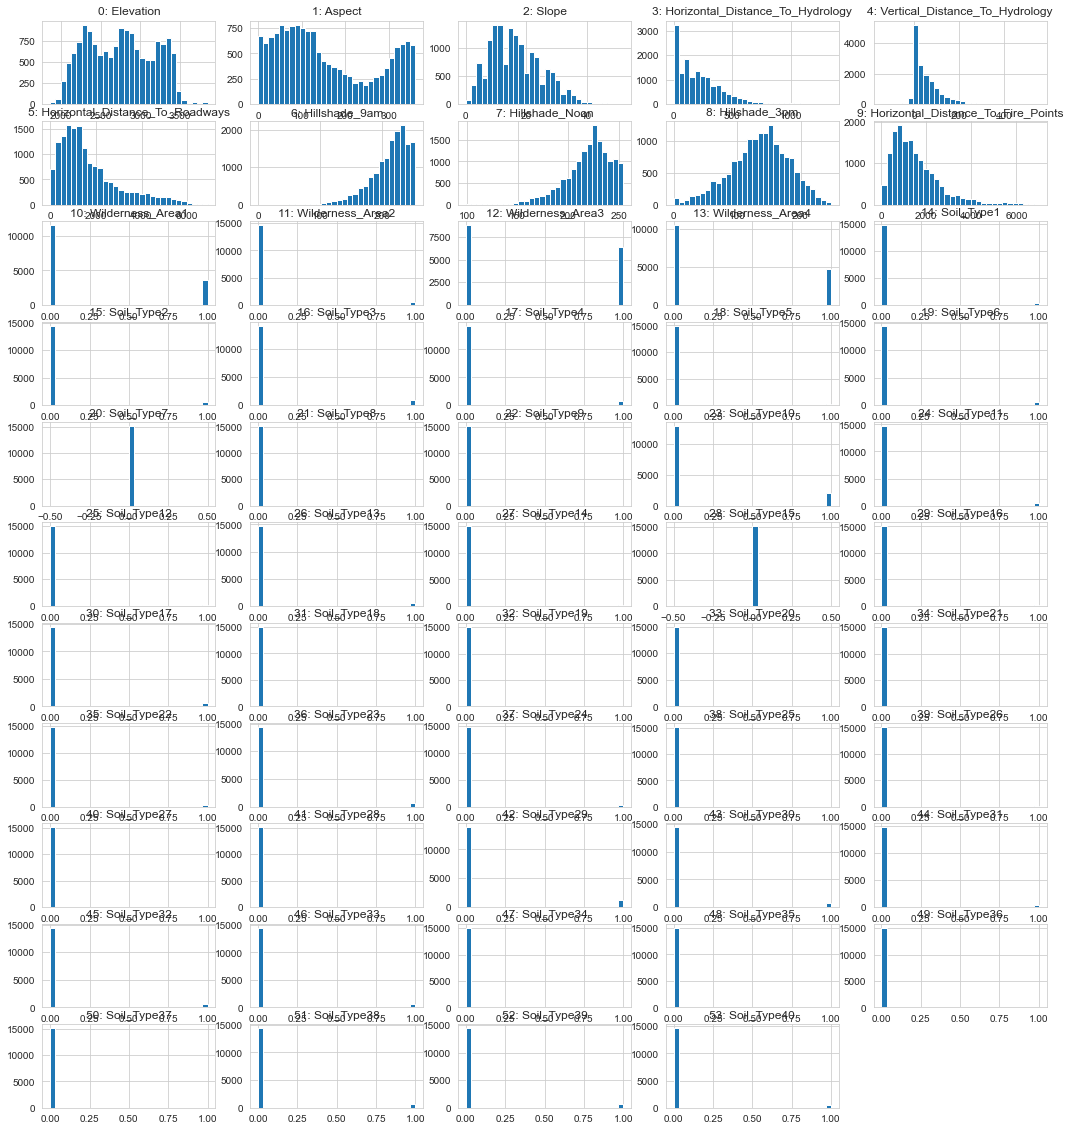

In [11]:
fig, axes = plt.subplots(11, 5, figsize=(18, 20))
for i, ax in enumerate(axes.ravel()):
    if i > 53:
        ax.set_visible(False)
        continue
    ax.hist(X_train.iloc[:, i], bins=30)
    ax.set_title("{}: {}".format(i, X_train.columns[i]))


Some variables are skewed to the left and others to the right. And some variables only have the one value.

Nevertheless, if a Random Forest is going to be applied, no transformation whatsoever is needed, since Decision Trees are not scale sensitive.

Furthermore, considering the size of the train set compared to the final test set, it would be risky to apply transformations to the data since we don't know the real distributions.

2.3 Standardization of variables

In this step we run different transformations of non_binary variables (log, square root, ext) to try to standarize the variables. But we arrived to the conclusion that with the small data set we got, we can´t conclude de distribution of the real variables and that we should only try scaling variables in the pipeline since that could also help normalizing data.

2.3 Correlation

For modeling it is important to have uncorrelated features, so we run the correlation matrix to visualize it.

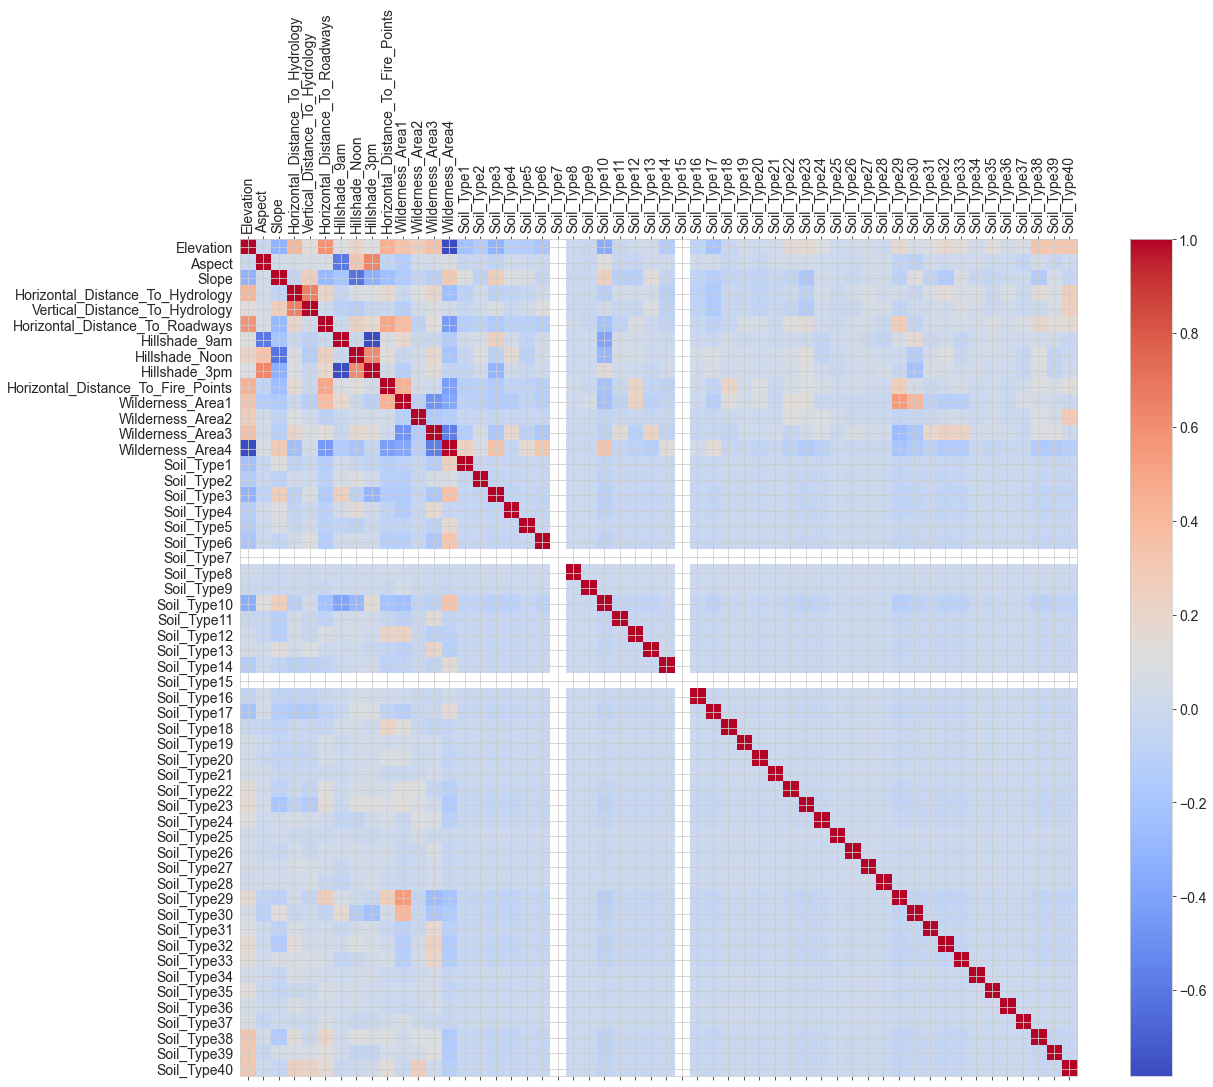

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=90)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [13]:
X_train.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Elevation,1.000000,-0.011154,-0.312756,0.412498,0.121982,0.578556,0.097946,0.215957,0.089580,0.443555,...,0.093218,0.172423,0.123858,0.021882,0.120200,0.038281,0.073852,0.323375,0.296514,0.306869
Aspect,-0.011154,1.000000,0.027981,0.040637,0.056311,0.066297,-0.593968,0.324909,0.635023,-0.052168,...,0.008144,0.003449,0.018697,0.012924,-0.004245,0.002828,-0.046320,0.044050,-0.031370,0.007189
Slope,-0.312756,0.027981,1.000000,-0.056054,0.265432,-0.277052,-0.200056,-0.612861,-0.327002,-0.239524,...,-0.076877,-0.147498,0.072017,-0.030598,-0.048870,-0.004659,0.003125,-0.148173,0.051886,-0.043537
Horizontal_Distance_To_Hydrology,0.412498,0.040637,-0.056054,1.000000,0.652166,0.203369,-0.033761,0.079913,0.080738,0.158885,...,0.060937,0.138065,0.062180,0.072531,-0.015446,0.072270,-0.009550,0.131784,0.066346,0.242465
Vertical_Distance_To_Hydrology,0.121982,0.056311,0.265432,0.652166,1.000000,0.011788,-0.095754,-0.133260,-0.035880,-0.015196,...,0.006274,0.019281,0.077244,0.028932,-0.021661,0.014683,-0.020721,-0.008797,0.059049,0.227268
Horizontal_Distance_To_Roadways,0.578556,0.066297,-0.277052,0.203369,0.011788,1.000000,-0.003609,0.240801,0.174103,0.486548,...,0.026693,0.031819,0.045835,0.021425,0.065338,0.028436,0.063325,0.197649,0.121014,0.144849
Hillshade_9am,0.097946,-0.593968,-0.200056,-0.033761,-0.095754,-0.003609,1.000000,-0.013678,-0.779965,0.078207,...,-0.017502,0.019124,-0.050708,0.004465,0.031247,0.013463,0.013217,0.012172,0.024535,-0.017204
Hillshade_Noon,0.215957,0.324909,-0.612861,0.079913,-0.133260,0.240801,-0.013678,1.000000,0.614504,0.122255,...,0.044683,0.095950,-0.013063,0.034170,0.034674,0.027523,-0.035377,0.104728,-0.058922,-0.008146
Hillshade_3pm,0.089580,0.635023,-0.327002,0.080738,-0.035880,0.174103,-0.779965,0.614504,1.000000,0.043184,...,0.052246,0.057832,0.024508,0.018302,0.000666,0.004030,-0.028057,0.069375,-0.056383,0.019167
Horizontal_Distance_To_Fire_Points,0.443555,-0.052168,-0.239524,0.158885,-0.015196,0.486548,0.078207,0.122255,0.043184,1.000000,...,-0.018481,0.016989,0.049044,-0.009919,0.004760,-0.008703,0.033259,0.090136,0.047902,0.128479


It seems we have some variables that are correlated. Later on we are going to apply PCA just to the non-binary variables to check if we can improve the model reducing the dimensions.

Another important thing to check is the distribution of the sample:

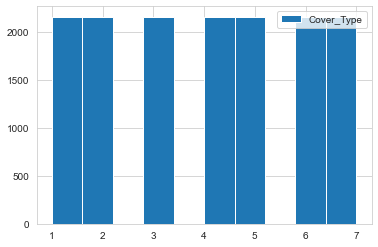

In [14]:
y_train.hist(label='Cover_Type')
plt.legend()

The Cover Type is equally distributed in our training set so we will not need to weight the classes later.

# 3. Feature engineering

We started this process by evaluating different processes for dealing with outliers, we decided to use the winsor function. This function use a floor and a cap for values outside a predefine tail cut.

We used a cut off tail of .01, since while running different tryouts we come to the conclusion that outliers where helping the model accuracy, so we left a "small" cut off and try the models with and without winsor function in the gridsearch.

3.1 Correlation with PCA and LDA

Since in part 2.3 we saw certain correlation between variables, we decided to evaluate the use of  PCA in a Pipeline, we algo evaluated using LDA, but that is a model by itself and with binary variables doesn´t make sense tu use it, since PCA will only be applyied to non_binary variables.

In [15]:
pca = PCA()

3.2 Outliers

To deal with outliers, we call a funciton con con winsorize that use a floor and a cap threshold to remove outlier, we used different level of threshold and decided to use a 1% floor and 1% cap as a final inpute for the function.

In [16]:
def winsor_01(serie):
    return winsorize(serie, limits=[0.01, 0.01])
winsor01 = FunctionTransformer(winsor_01)

3.3 Feature importance

We decided to start with Random Forest as primary model, since we intuitively thought that this would be the best model for this classification problem. RF is a good model for nonlinear solutions, it works well when you have different types of variables such as categorical and numerical and it  has good internal algorithms to avoid overfitting such as boosting, boat trap aggregation.

Still we run a grid search with a Support Vector Classifier and a Extra Tree Classifeir, to see if the model could be improved with another type of model.

In [17]:
rf = RandomForestClassifier(n_jobs=-1)
etc = ExtraTreesClassifier(random_state = 20, n_jobs = -1, max_features = 'auto', n_estimators=500)

In [18]:
etc = ExtraTreesClassifier(random_state = 20, n_jobs = -1, max_features = 'auto', n_estimators=500)

etc.fit(X_train,y_train)
cross_val_score(etc,X_train,y_train).mean()

0.8653394130549529

In [19]:
rf.fit(X_train,y_train)
cross_val_score(rf,X_train,y_train).mean()

0.8602438003981389

In [20]:
etc.fit(X_train,y_train)
cross_val_score(etc,X_train,y_train).mean()

0.8653394130549529

In [21]:
rf.score(X_test, y_test)

0.875

In [22]:
etc.score(X_test, y_test)

0.875

This is the first score for our test set.  We will used this initial scores as benchmarks when we run the gridsearch with a pipeline of transformations.



As next steps, to see if we can improve the baseline score. We run a feature_importance function, to see which variables are the most relevant in the model.

In [23]:
feature_importance = rf.feature_importances_
feature_importance_norm = pd.Series(np.std([tree.feature_importances_ for tree in rf.estimators_], axis = 0))\
.set_axis(X.columns).sort_values(ascending=False)

Text(0.5, 1.0, '"Mean decrease in impurity"')

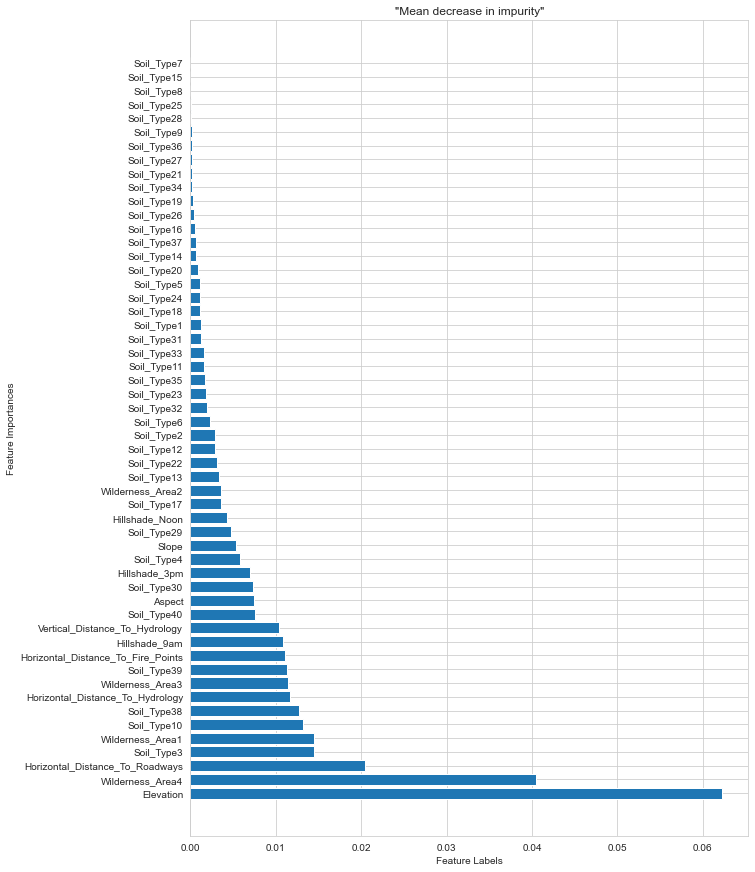

In [24]:
fig, axes = plt.subplots(figsize=(10,15))
plt.barh(feature_importance_norm.index,feature_importance_norm)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('"Mean decrease in impurity"')

This is a first view of the most important variables in our model. This might change after applying changes.

3.4 Binary and non_binary explanation

Now we are going to build a pipeline to start applying changes to our model.

We start by calling different type of scalers for the non_binaray variables as the PCA that we are gona use also on them.

In [25]:
norm = Normalizer()
robust = RobustScaler()

We generate a pipeline only for the nonbinary variables, since they will have different treatment: already scaled and no PCA applyied.

In [26]:
ct_nonbinary = Pipeline([
    ('scaler', norm),
    ('outliers', winsor01),
    ('pca', pca)
])
ct_nonbinary

Pipeline(steps=[('scaler', Normalizer()),
                ('outliers',
                 FunctionTransformer(func=<function winsor_01 at 0x0000013BACDCD670>)),
                ('pca', PCA())])

we generate a column transformer using the previos pipeline only for the non_binary variables, and the binary we only apply a passthrough.

In [27]:
ct = ColumnTransformer([
    ('non_binary', ct_nonbinary, slice(0,11)),
    ('passthrough', 'passthrough', slice(11,100))
])
ct

ColumnTransformer(transformers=[('non_binary',
                                 Pipeline(steps=[('scaler', Normalizer()),
                                                 ('outliers',
                                                  FunctionTransformer(func=<function winsor_01 at 0x0000013BACDCD670>)),
                                                 ('pca', PCA())]),
                                 slice(0, 11, None)),
                                ('passthrough', 'passthrough',
                                 slice(11, 100, None))])

for feature selection, we used the function SelectKBest with an initial k= 20, we will try different K values in the gridsearch.

In [28]:
skb = SelectKBest(f_classif, k=20)

we generarte the final pipeline with the transformer, feature selection and the model we are going to use. This will give us our benchmark score.

In [29]:
pipeline = Pipeline([
    ('transformer', ct),
    ('feature_selection', skb),
    ('model', etc)
])
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('non_binary',
                                                  Pipeline(steps=[('scaler',
                                                                   Normalizer()),
                                                                  ('outliers',
                                                                   FunctionTransformer(func=<function winsor_01 at 0x0000013BACDCD670>)),
                                                                  ('pca',
                                                                   PCA())]),
                                                  slice(0, 11, None)),
                                                 ('passthrough', 'passthrough',
                                                  slice(11, 100, None))])),
                ('feature_selection', SelectKBest(k=20)),
                ('model',
                 ExtraTreesClassifier(n_estimators=500, n_jobs=-1,
                                      random_state=20))])

In [30]:
cross_val_score(pipeline, X_train, y_train).mean()

0.7955274289130783

This is the baseline score for the pipeline. We are going to change hyperparameters to upgrade this score, and comparing it to the score we had applying a Random Forest with the default hyperparameters and no pipeline.

3.4 Creation and combinations of variables

As an extra step, independent of the previous pipelines generated, and after runing some of them we decided to add a new feature engeneering process. Since we got a small dataset, not that much information... we decided to add different combinations of features to our model (+/- of variables, mean, sqrt, median of the rows, etc..) and fit it directly to our best performing model until now ETC.

In [31]:
# 90% Crossvalidation /80 i kaggle  # with pipeline = 85%
import math
cols = list(X.columns)

for data in [X, df_test]:
    data['Hillshade'] = data['Hillshade_9am'] + data['Hillshade_3pm'] + data['Hillshade_Noon']
    data['binned_elev'] = [math.floor(v/50.0) for v in data['Elevation']]
    data['Elevation_Fire_Points'] = data['Elevation']+data['Horizontal_Distance_To_Fire_Points']
#    data['Elevation_Distance_To_Roadways'] = data['Elevation']+data['Horizontal_Distance_To_Roadways']
    data['Road_Fire'] = data['Horizontal_Distance_To_Roadways'] + data['Horizontal_Distance_To_Fire_Points']
    data['Road-Fire1'] = data['Horizontal_Distance_To_Roadways'] - data['Horizontal_Distance_To_Fire_Points']
    data['Ele_Road_Fire_Hydro'] = data['Elevation'] + data['Horizontal_Distance_To_Roadways']  + data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Hydrology']
    data['Ele-Road'] = data['Elevation'] + data['Horizontal_Distance_To_Roadways']
    data['Ele_Road1'] = data['Elevation'] - data['Horizontal_Distance_To_Roadways']
    data['Ele-Fire'] = data['Elevation'] + data['Horizontal_Distance_To_Fire_Points']
    data['Ele_Fire1'] = data['Elevation'] - data['Horizontal_Distance_To_Fire_Points']
    data['Ele_Hillshade'] = data['Elevation'] - data['Hillshade']
    data['Ele-Hillshade1'] = data['Elevation'] + data['Hillshade']
    #None elevation combos:
    data['Soil_W1'] = data['Wilderness_Area1'] + data['Soil_Type29'] 
    data['Soil_W4'] = data['Wilderness_Area4'] + data['Soil_Type3']
    data['Soil_W3'] = data['Wilderness_Area3'] + data['Soil_Type1']
#    data['Soil_W5'] = data['Wilderness_Area2'] + data['Soil_Type2']
    data['Hydrology_Total'] = abs(data["Horizontal_Distance_To_Hydrology"])+abs(data['Vertical_Distance_To_Hydrology'])
    #Summary metrics
    data["mean"] = data[cols].mean(axis=1)
    data["min"] = data[cols].min(axis=1)
    data["max"] = data[cols].max(axis=1)
    data["std"] = data[cols].std(axis=1)
    data["median"] = data[cols].median(axis=1)

In [32]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0005)

etc = ExtraTreesClassifier(random_state = 20, n_jobs = -1, max_features = 'auto', n_estimators=500)

etc.fit(X_train, y_train)

pred_valid_etc = etc.predict(X_test)

cross_val_score(etc, X_train, y_train).mean()


0.897432479383189

We tried different combinations of variables, and kept the ones that improved the crossvalidation score. The result was quite good, the score was 4% higher than the benchmark ( the one we got directly with the raw data), so we decided to use this dataset as the new one. Use that dataset with greater dimension in the pipeline during the modeling stage

# 4.  Modeling 

Note: Most Code of this section is commented since running all the GridSearch combinations we wanted was almost impossible regarding time.

For our GridSearch we started by defining different ranges for the pipeline inputs, that by running some previous test, we thought they could improved the model score.

In [33]:
rf_depth = range(30,35)
n_features = range(35,45)
max_features = 10**np.linspace(-2,0,15)
n_estimators = range(490,510)

We define a param_grid that would go one by one, trying each input combination and giving un the final score for us to compare, important to mention that our oringial param_grid was way longer than this final; it included a model variation with SVC with different types of kernels, but it was totally inefficient. So we only run a couple of test to confirm that the RF was the best model for this classification problem and took out some variations of the gridsearch for efficieny porpuse.

In [34]:
param_grid = [
    {'model': [etc], 
             'model__n_estimators': n_estimators},
    {'model': [rf], 'model__max_depth': rf_depth, 
             'model__max_depth': rf_depth, 
             'model__max_features': max_features, 
             'feature_selection__k': n_features},
]

In [35]:
param_grid = [
    {'model': [etc], 
             'model__n_estimators': n_estimators},
]

In [36]:
num_par = len(list(ParameterGrid(param_grid)))
num_par

20

In [37]:
et = (num_par / 30)/60
F'Estimated time: {et} hours or {et*60} minutes for Random Forest'

'Estimated time: 0.01111111111111111 hours or 0.6666666666666666 minutes for Random Forest'

In [38]:
#%%time
#gs = GridSearchCV(
#    pipeline,
#    param_grid = param_grid,
#    cv = 5,
#    n_jobs=-1
#)
#gs.fit(X_train, y_train)

We run the best_params_ function get you the best model run by the gridsearch, this process is commented since it take quite a lot of time to run it. And the results were pretty bad.


In [39]:
#best_params = gs.best_params_
#best_params

Important Findings of the GridSearch:

We got around a 75% of accuracy with the best_params, we tried different combinations of the param_grid to see which step of the pipeline was affecting so negatively our results. We removed one by one each step of the pipeline and conclude that, that each time we add a step we were losing important information for the model, the Outliers, the normalization process, scalers, they were taking away relevant info. This make us conclude that creating new info rather than limiting it was still the best way to attack this problem.

We decided to keep the original model fit of the ETC with the combine and transform dataset, which got a 90% of accuracy (section 3.4)


In [40]:
#gs.best_score_

In [41]:
#gs_results = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score')

In [42]:
#gs_results

In [43]:
#gs_results.sort_values('param_model__max_features').plot('param_model__max_features','mean_test_score')

# 6. Model evaluation

The model did improved, we got from a 0.8123897 score that we got for benchmark, to a .8441358 by changing some parameters with our final model 

In [44]:
#gs.score(X_test, y_test)

we change the pipeline with the parameters that we got of the gridsearch, parameters of our final model.

In [45]:
#pipeline.set_params(**best_params)

In [46]:
#pipeline.fit(X_train, y_train)

In [47]:
#pipeline.score(X_test, y_test)

In [48]:
#df_test.head()

In [49]:
#results = pipeline.predict(df_test)
#results

As final results, we are getting the prediction of section 3.4

In [50]:
results = etc.predict(df_test) # ETC with transformation and combinations results
results

array([1, 1, 1, ..., 3, 3, 3], dtype=int64)

In [51]:
final_results = pd.DataFrame(results, columns=['Cover_Type']).set_index(df_test.index).reset_index()
final_results.head()

,Id,Cover_Type
0,15121,1
1,15122,1
2,15123,1
3,15124,1
4,15125,1


In [52]:
#final_results.to_csv('submission.csv', index=False)